This script trains a small decoder to reconstruct STL-10 images from frozen CLIP
embeddings. After training, it performs SLERP interpolation between pairs of CLIP
embeddings and decodes the results to visualize smooth semantic blends between
image classes.

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as T
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------------------------
# 0. CONFIGURATION
# -----------------------------------------------------------------------------
try:
    import open_clip
except ImportError:
    print("Please install open_clip: pip install open_clip_torch")
    exit()

CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 64,
    "lr": 1e-3,
    "epochs": 100,
    "img_size": 96,        # STL-10 Native Resolution
    "embed_dim": 512,      # ViT-B-32
    "output_dir": "stl10_outputs"
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)
print(f"Running STL-10 Context Blender on {CONFIG['device']}...")

# -----------------------------------------------------------------------------
# 1. DATASET: STL-10 (96x96 Real Images)
# -----------------------------------------------------------------------------
def get_stl10_loader():
    print("Downloading/Loading STL-10 (this might take a minute)...")

    # STL-10 Normalization
    stats = ((0.4467, 0.4398, 0.4066), (0.2603, 0.2566, 0.2713))

    transform = T.Compose([
        T.Resize(CONFIG['img_size']), # Explicitly ensure 96x96
        T.ToTensor(),
        T.Normalize(*stats)
    ])
    # use train for faster training
    dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)

    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True)
    return loader, dataset, stats

# -----------------------------------------------------------------------------
# 2. MODELS: CLIP ENCODER & UPSAMPLE DECODER
# -----------------------------------------------------------------------------
class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model, _, _ = open_clip.create_model_and_transforms(
            'ViT-B-32', pretrained='laion2b_s34b_b79k'
        )
        self.model.eval()
        self.model.to(CONFIG['device'])

        self.register_buffer("mean", torch.tensor([0.481, 0.457, 0.408]).view(1,3,1,1))
        self.register_buffer("std", torch.tensor([0.268, 0.261, 0.275]).view(1,3,1,1))

    @torch.no_grad()
    def forward(self, images, denorm_stats):
        dm, ds = denorm_stats
        x = images * torch.tensor(ds).view(1,3,1,1).to(CONFIG['device']) + \
            torch.tensor(dm).view(1,3,1,1).to(CONFIG['device'])

        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        x = (x - self.mean) / self.std

        features = self.model.encode_image(x)
        return features.float() / features.norm(dim=-1, keepdim=True)

class ContextDecoder(nn.Module):
    """
    Decodes 512-dim embedding back to 96x96 image.
    Uses upsampling blocks.
    """
    def __init__(self, embed_dim=512):
        super().__init__()

        self.init_h = 6
        self.dim = 256

        self.fc = nn.Linear(embed_dim, self.dim * self.init_h * self.init_h)

        self.blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.ReLU(True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.ReLU(True),

            nn.Conv2d(16, 3, 3, 1, 1)
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim, self.init_h, self.init_h)
        return self.blocks(x)

# -----------------------------------------------------------------------------
# 3. TRAINING LOOP
# -----------------------------------------------------------------------------
def train_stl10():
    loader, dataset, stats = get_stl10_loader()

    encoder = CLIPEncoder()
    decoder = ContextDecoder().to(CONFIG['device'])

    optimizer = optim.Adam(decoder.parameters(), lr=CONFIG['lr'])
    criterion = nn.MSELoss()

    print(f"Starting training on {len(dataset)} images...")

    for epoch in range(CONFIG['epochs']):
        decoder.train()
        total_loss = 0

        for batch_idx, (images, _) in enumerate(loader):
            images = images.to(CONFIG['device'])

            with torch.no_grad():
                embeddings = encoder(images, stats)

            recon = decoder(embeddings)
            loss = criterion(recon, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if batch_idx % 20 == 0:
                print(f"Epoch {epoch+1} | Batch {batch_idx} | Loss: {loss.item():.4f}")

        avg_loss = total_loss / len(loader)
        print(f"=== Epoch {epoch+1} Complete. Avg Loss: {avg_loss:.4f} ===")

        torch.save(decoder.state_dict(), f"{CONFIG['output_dir']}/decoder_epoch_{epoch+1}.pt")

    return encoder, decoder, stats, dataset

# -----------------------------------------------------------------------------
# 4. CONTEXT BLENDING VIZ
# -----------------------------------------------------------------------------
def visualize_context_blends(encoder, decoder, stats, dataset):
    print("Generating Contextual Blends...")
    decoder.eval()


    class_map = {
        0: 'airplane', 1: 'bird', 2: 'car', 3: 'cat', 4: 'deer',
        5: 'dog', 6: 'horse', 7: 'monkey', 8: 'ship', 9: 'truck'
    }

    # find 1 example of each class
    examples = {}
    indices = np.random.permutation(len(dataset))
    for idx in indices:
        img, label = dataset[idx]
        if label not in examples:
            examples[label] = img
        if len(examples) == 10: break

    # define interesting pairs
    pairs = [
        (0, 8),
        (4, 2),
        (1, 0),
        (6, 9),
    ]

    steps = 10
    fig, axes = plt.subplots(len(pairs), steps, figsize=(20, 2.5 * len(pairs)))

    dm, ds = stats
    mean = torch.tensor(dm).view(1,3,1,1)
    std = torch.tensor(ds).view(1,3,1,1)

    with torch.no_grad():
        for row, (c1, c2) in enumerate(pairs):
            img1 = examples[c1].unsqueeze(0).to(CONFIG['device'])
            img2 = examples[c2].unsqueeze(0).to(CONFIG['device'])

            emb1 = encoder(img1, stats)
            emb2 = encoder(img2, stats)

            # slerp
            theta = torch.acos(torch.sum(emb1 * emb2))
            sin_theta = torch.sin(theta)

            for col, alpha in enumerate(np.linspace(0, 1, steps)):
                if sin_theta < 1e-6:
                    mixed = (1-alpha)*emb1 + alpha*emb2
                else:
                    w1 = torch.sin((1-alpha)*theta) / sin_theta
                    w2 = torch.sin(alpha*theta) / sin_theta
                    mixed = w1*emb1 + w2*emb2

                recon = decoder(mixed)

                viz = recon.cpu() * std + mean
                viz = viz.clamp(0, 1).squeeze().permute(1, 2, 0).numpy()

                ax = axes[row, col] if len(pairs) > 1 else axes[col]
                ax.imshow(viz)
                ax.axis('off')

                if col == 0: ax.set_title(class_map[c1])
                if col == steps - 1: ax.set_title(class_map[c2])

    save_path = f"{CONFIG['output_dir']}/stl10_blends.png"
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Visualization saved to {save_path}")

if __name__ == "__main__":
    enc, dec, stats, ds = train_stl10()
    visualize_context_blends(enc, dec, stats, ds)

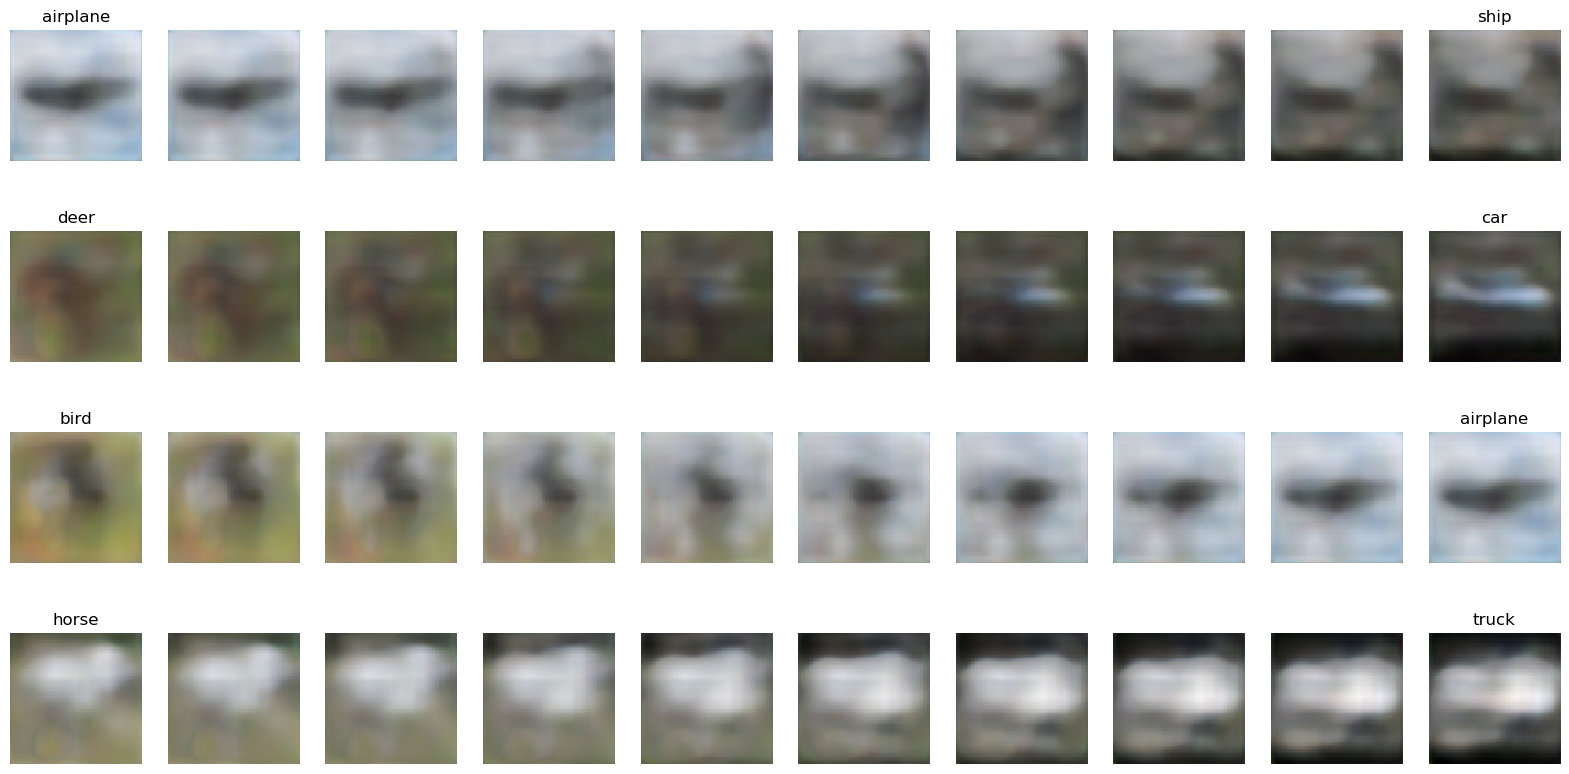

Trains a CLIP-conditioned GAN on STL-10 images. Images are resized and normalized, then passed through a frozen CLIP encoder to get 512-dimensional embeddings.
The generator upsamples these embeddings into 96×96 RGB images, while the discriminator learns to distinguish real from fake.
Training uses adversarial loss for realism plus L1 reconstruction loss to match the input.
The output includes the trained encoder and generator, and a visualization that interpolates between embeddings to create smooth image blends.

In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.datasets as datasets
import numpy as np
import matplotlib.pyplot as plt
import os

# -----------------------------------------------------------------------------
# 0. CONFIGURATION
# -----------------------------------------------------------------------------
try:
    import open_clip
except ImportError:
    print("Please install open_clip: pip install open_clip_torch")
    exit()

CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 64,
    "lr_g": 2e-4,
    "lr_d": 1e-4,
    "epochs": 100,
    "img_size": 96,
    "embed_dim": 512,
    "output_dir": "stl10_gan_outputs"
}

os.makedirs(CONFIG["output_dir"], exist_ok=True)
print(f"Running STL-10 GAN on {CONFIG['device']}...")

# -----------------------------------------------------------------------------
# 1. DATASET: STL-10
# -----------------------------------------------------------------------------
def get_stl10_loader():
    transform = T.Compose([
        T.Resize(CONFIG['img_size']),
        T.ToTensor(),
        T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    dataset = datasets.STL10(root='./data', split='train', download=True, transform=transform)
    loader = DataLoader(dataset, batch_size=CONFIG['batch_size'], shuffle=True, drop_last=True)
    return loader, dataset

# -----------------------------------------------------------------------------
# 2. MODELS
# -----------------------------------------------------------------------------

class CLIPEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.model, _, _ = open_clip.create_model_and_transforms(
            'ViT-B-32', pretrained='laion2b_s34b_b79k'
        )
        self.model.eval()
        self.model.to(CONFIG['device'])

        # CLIP Stats
        self.register_buffer("clip_mean", torch.tensor([0.481, 0.457, 0.408]).view(1,3,1,1))
        self.register_buffer("clip_std", torch.tensor([0.268, 0.261, 0.275]).view(1,3,1,1))

    @torch.no_grad()
    def forward(self, images):
        x = (images + 1) * 0.5

        # 224 for CLIP
        x = torch.nn.functional.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)

        # Normalize for CLIP
        x = (x - self.clip_mean) / self.clip_std

        features = self.model.encode_image(x)
        return features.float() / features.norm(dim=-1, keepdim=True)

class Generator(nn.Module):
    """
    Same as ContextDecoder but with LeakyReLU and Tanh for GAN stability.
    """
    def __init__(self, embed_dim=512):
        super().__init__()
        self.init_h = 6
        self.dim = 256

        self.fc = nn.Linear(embed_dim, self.dim * self.init_h * self.init_h)

        self.blocks = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(256, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.LeakyReLU(0.2, True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.LeakyReLU(0.2, True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(64, 32, 3, 1, 1), nn.BatchNorm2d(32), nn.LeakyReLU(0.2, True),

            nn.Upsample(scale_factor=2),
            nn.Conv2d(32, 16, 3, 1, 1), nn.BatchNorm2d(16), nn.LeakyReLU(0.2, True),

            nn.Conv2d(16, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(-1, self.dim, self.init_h, self.init_h)
        return self.blocks(x)

class Discriminator(nn.Module):
    """
    The Critic. Tells if an image is Real (1) or Fake (0).
    Simple Strided CNN (DCGAN style).
    """
    def __init__(self):
        super().__init__()

        def d_block(in_f, out_f, bn=True):
            block = [nn.Conv2d(in_f, out_f, 4, 2, 1), nn.LeakyReLU(0.2, True)]
            if bn: block.append(nn.BatchNorm2d(out_f))
            return block

        self.model = nn.Sequential(
            *d_block(3, 32, bn=False),

            *d_block(32, 64),
            *d_block(64, 128),
            *d_block(128, 256),
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 1),
        )

    def forward(self, img):
        return self.model(img)

# -----------------------------------------------------------------------------
# 3. GAN TRAINING LOOP
# -----------------------------------------------------------------------------
def train_gan():
    loader, dataset = get_stl10_loader()

    encoder = CLIPEncoder()
    generator = Generator().to(CONFIG['device'])
    discriminator = Discriminator().to(CONFIG['device'])

    opt_g = optim.Adam(generator.parameters(), lr=CONFIG['lr_g'], betas=(0.5, 0.999))
    opt_d = optim.Adam(discriminator.parameters(), lr=CONFIG['lr_d'], betas=(0.5, 0.999))

    adversarial_loss = nn.BCEWithLogitsLoss()
    reconstruction_loss = nn.L1Loss() # L1 is less blurry than MSE

    print(f"Starting GAN Training on {len(dataset)} images...")

    for epoch in range(CONFIG['epochs']):
        generator.train()

        for i, (real_imgs, _) in enumerate(loader):
            real_imgs = real_imgs.to(CONFIG['device'])
            batch_size = real_imgs.size(0)

            valid = torch.ones(batch_size, 1).to(CONFIG['device'])
            fake_labels = torch.zeros(batch_size, 1).to(CONFIG['device'])

            opt_d.zero_grad()

            with torch.no_grad():
                embeddings = encoder(real_imgs)

            fake_imgs = generator(embeddings)

            real_pred = discriminator(real_imgs)
            d_real_loss = adversarial_loss(real_pred, valid)

            fake_pred = discriminator(fake_imgs.detach())
            d_fake_loss = adversarial_loss(fake_pred, fake_labels)

            d_loss = (d_real_loss + d_fake_loss) / 2
            d_loss.backward()
            opt_d.step()

            opt_g.zero_grad()

            validity = discriminator(fake_imgs)
            g_adv_loss = adversarial_loss(validity, valid)

            g_recon_loss = reconstruction_loss(fake_imgs, real_imgs)

            g_loss = g_adv_loss + (100 * g_recon_loss)

            g_loss.backward()
            opt_g.step()

            if i % 50 == 0:
                print(f"Epoch {epoch+1} | D: {d_loss.item():.4f} | G_Adv: {g_adv_loss.item():.4f} | G_Rec: {g_recon_loss.item():.4f}")

    return encoder, generator, dataset

# -----------------------------------------------------------------------------
# 4. SHARP VIZ
# -----------------------------------------------------------------------------
def visualize_sharp_blends(encoder, generator, dataset):
    print("Generating Sharp Blends...")
    generator.eval()

    class_map = {0: 'airplane', 8: 'ship', 4: 'deer', 2: 'car', 1: 'bird', 6: 'horse', 9: 'truck'}

    examples = {}
    indices = np.random.permutation(len(dataset))
    for idx in indices:
        img, label = dataset[idx]
        if label not in examples: examples[label] = img
        if len(examples) == 10: break

    pairs = [(0, 8), (4, 2), (1, 0), (6, 9)]
    steps = 10
    fig, axes = plt.subplots(len(pairs), steps, figsize=(20, 2.5 * len(pairs)))

    with torch.no_grad():
        for row, (c1, c2) in enumerate(pairs):
            img1 = examples[c1].unsqueeze(0).to(CONFIG['device'])
            img2 = examples[c2].unsqueeze(0).to(CONFIG['device'])

            emb1 = encoder(img1)
            emb2 = encoder(img2)

            # Slerp
            theta = torch.acos(torch.sum(emb1 * emb2))
            sin_theta = torch.sin(theta)

            for col, alpha in enumerate(np.linspace(0, 1, steps)):
                if sin_theta < 1e-6:
                    mixed = (1-alpha)*emb1 + alpha*emb2
                else:
                    w1 = torch.sin((1-alpha)*theta)/sin_theta
                    w2 = torch.sin(alpha*theta)/sin_theta
                    mixed = w1*emb1 + w2*emb2

                recon = generator(mixed)

                viz = (recon.cpu() + 1) / 2
                viz = viz.clamp(0, 1).squeeze().permute(1, 2, 0).numpy()

                ax = axes[row, col] if len(pairs) > 1 else axes[col]
                ax.imshow(viz)
                ax.axis('off')

                if col == 0: ax.set_title(class_map.get(c1, ''))
                if col == steps - 1: ax.set_title(class_map.get(c2, ''))

    save_path = f"{CONFIG['output_dir']}/sharp_blends.png"
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Saved to {save_path}")

if __name__ == "__main__":
    enc, gen, ds = train_gan()
    visualize_sharp_blends(enc, gen, ds)

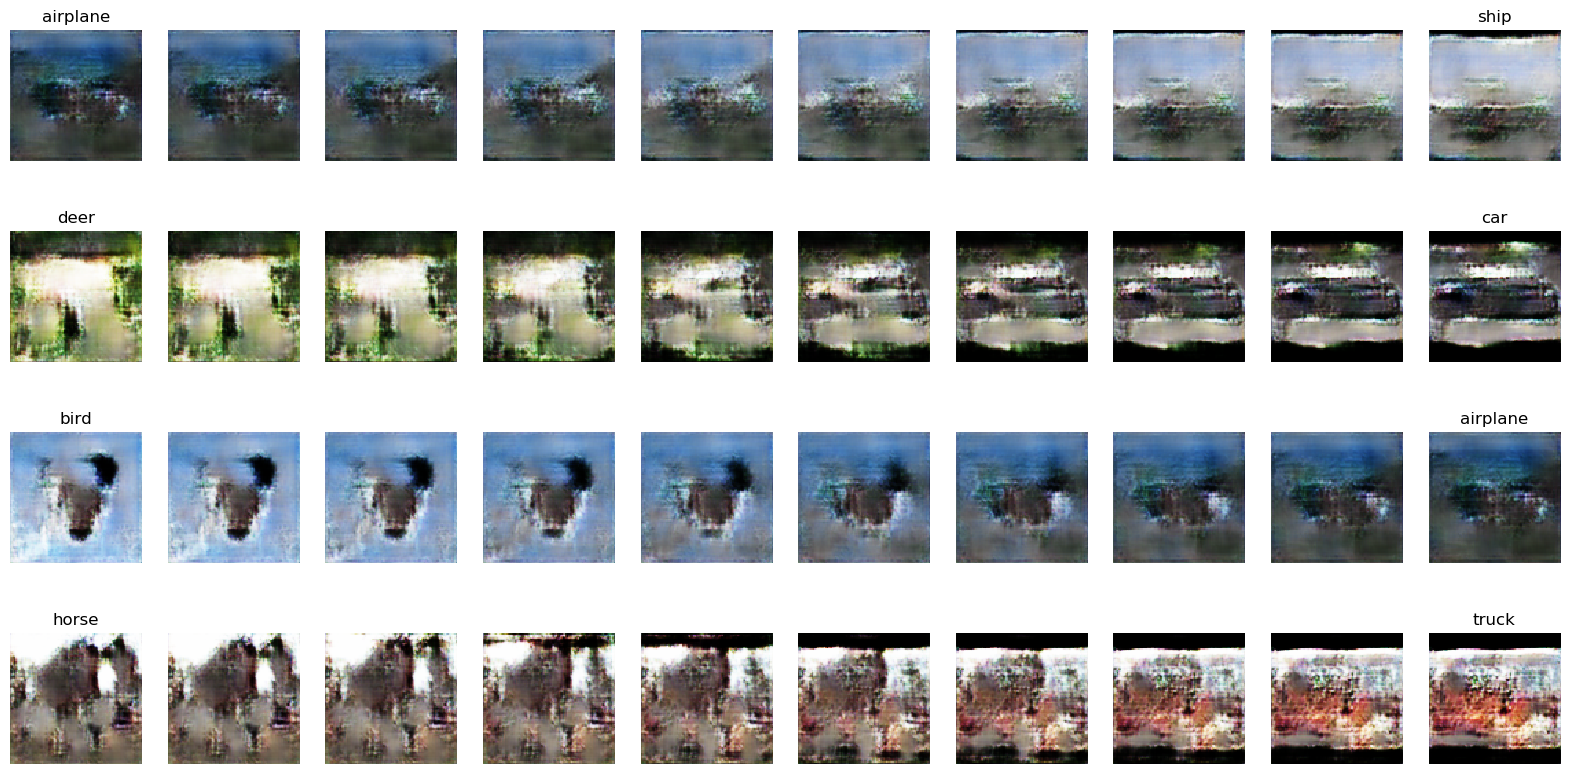

CLIP-conditioned GAN on STL-10 with SLERP blending, AMP, checkpointing.


In [ ]:


import os
import sys
import time
import math
import argparse
import subprocess
from pathlib import Path

# -------------------------
# install missing packages
# -------------------------
def _pip_install(pkg):
    print(f"[installer] pip installing {pkg} ...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])

try:
    import torch
    import torchvision
    import torchvision.transforms as T
    import torchvision.datasets as datasets
    import numpy as np
    import matplotlib.pyplot as plt
    import PIL
except Exception as e:
    print("Missing core packages; attempting to install torch, torchvision, pillow, matplotlib, numpy")
    _pip_install("torch")
    _pip_install("torchvision")
    _pip_install("pillow")
    _pip_install("matplotlib")
    _pip_install("numpy")
    import torch
    import torchvision
    import torchvision.transforms as T
    import torchvision.datasets as datasets
    import numpy as np
    import matplotlib.pyplot as plt
    import PIL

try:
    import open_clip
except Exception:
    try:
        _pip_install("open_clip_torch")
        import open_clip
    except Exception as e:
        print("Failed to install open_clip_torch automatically. Please install manually: pip install open_clip_torch")
        raise

# -------------------------
# CONFIG (edit these as needed)
# -------------------------
ROOT = Path.cwd() / "gan_clip_run"
ROOT.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR = ROOT / "outputs"
CKPT_DIR = ROOT / "checkpoints"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CKPT_DIR.mkdir(parents=True, exist_ok=True)

CONFIG = {
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "batch_size": 64,
    "lr_g": 2e-4,
    "lr_d": 1e-4,
    "epochs": 100,
    "img_size": 96,
    "embed_dim": 512,
    "output_dir": str(OUTPUT_DIR),
    "checkpoint_dir": str(CKPT_DIR),
    "print_every": 50,
    "recon_weight": 100.0,
    "grad_clip": 1.0,
    "use_amp": True
}

print("Config:", CONFIG)
print("Device:", CONFIG["device"])

# -------------------------
# Dataset + DataLoader
# -------------------------
from torch.utils.data import DataLoader

def get_stl10_loader(batch_size, img_size, download_root):
    transform = T.Compose([
        T.Resize(img_size),
        T.CenterCrop(img_size),
        T.ToTensor(),
        T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
    ])
    ds = datasets.STL10(root=download_root, split='train', download=True, transform=transform)
    loader = DataLoader(ds, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4, pin_memory=True)
    return loader, ds

# -------------------------
# Models: CLIP Encoder wrapper, Generator, Discriminator
# -------------------------
import torch.nn as nn
import torch.nn.functional as F

class CLIPEncoder(nn.Module):
    def __init__(self, model_name="ViT-B-32", pretrained="laion2b_s34b_b79k"):
        super().__init__()

        model, _, _ = open_clip.create_model_and_transforms(model_name, pretrained=pretrained)
        model.eval()
        self.model = model.to(CONFIG["device"])

        self.register_buffer("clip_mean", torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(1,3,1,1))
        self.register_buffer("clip_std",  torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(1,3,1,1))

    @torch.no_grad()
    def forward(self, images):

        x = (images + 1.0) * 0.5
        x = F.interpolate(x, size=(224,224), mode='bilinear', align_corners=False)
        x = (x - self.clip_mean.to(x.device)) / self.clip_std.to(x.device)
        feats = self.model.encode_image(x)
        feats = feats.float()

        feats = feats / (feats.norm(dim=-1, keepdim=True) + 1e-6)
        return feats

# Generator: maps CLIP embedding (or batch of embeddings) to image
class Generator(nn.Module):
    def __init__(self, embed_dim=512, init_h=6, dim=256):
        super().__init__()
        self.init_h = init_h
        self.dim = dim
        self.fc = nn.Linear(embed_dim, dim * init_h * init_h)
        # Upsample blocks
        self.blocks = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(dim, dim//2, 3, 1, 1), nn.BatchNorm2d(dim//2), nn.LeakyReLU(0.2, True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(dim//2, dim//4, 3, 1, 1), nn.BatchNorm2d(dim//4), nn.LeakyReLU(0.2, True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(dim//4, dim//8, 3, 1, 1), nn.BatchNorm2d(dim//8), nn.LeakyReLU(0.2, True),

            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(dim//8, dim//16, 3, 1, 1), nn.BatchNorm2d(dim//16), nn.LeakyReLU(0.2, True),

            nn.Conv2d(dim//16, 3, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.dim, self.init_h, self.init_h)
        return self.blocks(x)

class Discriminator(nn.Module):
    def __init__(self, img_size=96):
        super().__init__()
        def d_block(in_c, out_c, bn=True):
            layers = [nn.Conv2d(in_c, out_c, 4, 2, 1), nn.LeakyReLU(0.2, True)]
            if bn:
                layers.append(nn.BatchNorm2d(out_c))
            return layers

        self.model = nn.Sequential(
            *d_block(3, 32, bn=False),  # 96->48
            *d_block(32, 64),           # 48->24
            *d_block(64, 128),          # 24->12
            *d_block(128, 256),         # 12->6
            nn.Flatten(),
            nn.Linear(256 * 6 * 6, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------
# Utilities: checkpoint, slerp, save image
# -------------------------
def slerp_batch(a, b, t: float):
    # a,b: [B, D]
    a_n = F.normalize(a, dim=-1)
    b_n = F.normalize(b, dim=-1)
    dot = (a_n * b_n).sum(dim=-1).clamp(-1+1e-6, 1-1e-6)
    omega = torch.acos(dot)
    so = torch.sin(omega)
    t = float(t)
    small = (so.abs() < 1e-6)
    coeff1 = torch.where(small, 1.0 - t, torch.sin((1.0 - t) * omega) / so)
    coeff2 = torch.where(small, t, torch.sin(t * omega) / so)
    coeff1 = coeff1.unsqueeze(1)
    coeff2 = coeff2.unsqueeze(1)
    return coeff1 * a + coeff2 * b

def save_checkpoint(generator, discriminator, opt_g, opt_d, epoch):
    pgen = Path(CONFIG["checkpoint_dir"]) / "generator.pt"
    pdis = Path(CONFIG["checkpoint_dir"]) / "discriminator.pt"
    torch.save({"epoch": epoch, "model": generator.state_dict(), "opt": opt_g.state_dict()}, str(pgen))
    torch.save({"epoch": epoch, "model": discriminator.state_dict(), "opt": opt_d.state_dict()}, str(pdis))
    print(f"[ckpt] saved epoch {epoch} -> {pgen}, {pdis}")

def load_checkpoint(generator, discriminator, opt_g=None, opt_d=None):
    pgen = Path(CONFIG["checkpoint_dir"]) / "generator.pt"
    pdis = Path(CONFIG["checkpoint_dir"]) / "discriminator.pt"
    start_epoch = 0
    if pgen.exists():
        ck = torch.load(str(pgen), map_location=CONFIG["device"])
        generator.load_state_dict(ck["model"])
        if opt_g is not None:
            opt_g.load_state_dict(ck["opt"])
        start_epoch = ck.get("epoch", 0) + 1
        print(f"[ckpt] loaded generator epoch {ck.get('epoch',0)}")
    if pdis.exists():
        ck = torch.load(str(pdis), map_location=CONFIG["device"])
        discriminator.load_state_dict(ck["model"])
        if opt_d is not None:
            opt_d.load_state_dict(ck["opt"])
        print(f"[ckpt] loaded discriminator epoch {ck.get('epoch',0)}")
    return start_epoch

def tensor_to_image(tensor):
    img = (tensor.clamp(-1,1) + 1.0) / 2.0
    np_img = (img.cpu().permute(1,2,0).numpy() * 255).astype('uint8')
    return np_img

# -------------------------
# Training loop
# -------------------------
def train_gan():
    loader, dataset = get_stl10_loader(CONFIG["batch_size"], CONFIG["img_size"], ROOT / "data")
    encoder = CLIPEncoder()
    generator = Generator(embed_dim=CONFIG["embed_dim"]).to(CONFIG["device"])
    discriminator = Discriminator(img_size=CONFIG["img_size"]).to(CONFIG["device"])

    opt_g = torch.optim.Adam(generator.parameters(), lr=CONFIG["lr_g"], betas=(0.5, 0.999))
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=CONFIG["lr_d"], betas=(0.5, 0.999))

    adversarial_loss = nn.BCEWithLogitsLoss()
    recon_loss = nn.L1Loss()

    scaler = torch.cuda.amp.GradScaler(enabled=CONFIG["use_amp"])

    start_epoch = load_checkpoint(generator, discriminator, opt_g, opt_d)
    total_steps = 0

    for epoch in range(start_epoch, CONFIG["epochs"]):
        t0 = time.time()
        generator.train(); discriminator.train()
        for i, (real_imgs, _) in enumerate(loader):
            real_imgs = real_imgs.to(CONFIG["device"], non_blocking=True)
            bs = real_imgs.size(0)
            valid = torch.ones(bs, 1, device=CONFIG["device"])
            fake_labels = torch.zeros(bs, 1, device=CONFIG["device"])

            # Train Discriminator
            opt_d.zero_grad()
            with torch.no_grad():
                embeddings = encoder(real_imgs)

            with torch.cuda.amp.autocast(enabled=CONFIG["use_amp"]):
                fake_imgs = generator(embeddings)
                pred_real = discriminator(real_imgs)
                pred_fake = discriminator(fake_imgs.detach())
                d_real_loss = adversarial_loss(pred_real, valid)
                d_fake_loss = adversarial_loss(pred_fake, fake_labels)
                d_loss = 0.5 * (d_real_loss + d_fake_loss)

            scaler.scale(d_loss).backward()
            if CONFIG["grad_clip"] is not None:
                scaler.unscale_(opt_d)
                torch.nn.utils.clip_grad_norm_(discriminator.parameters(), CONFIG["grad_clip"])
            scaler.step(opt_d)
            scaler.update()

            # train generator
            opt_g.zero_grad()
            with torch.cuda.amp.autocast(enabled=CONFIG["use_amp"]):
                fake_imgs = generator(embeddings)
                pred = discriminator(fake_imgs)
                g_adv = adversarial_loss(pred, valid)
                g_rec = recon_loss(fake_imgs, real_imgs)
                g_loss = g_adv + CONFIG["recon_weight"] * g_rec

            scaler.scale(g_loss).backward()
            if CONFIG["grad_clip"] is not None:
                scaler.unscale_(opt_g)
                torch.nn.utils.clip_grad_norm_(generator.parameters(), CONFIG["grad_clip"])
            scaler.step(opt_g)
            scaler.update()

            if (i % CONFIG["print_every"]) == 0:
                print(f"[Epoch {epoch+1}/{CONFIG['epochs']}] Batch {i}/{len(loader)} "
                      f"D_loss={d_loss.item():.4f} G_adv={g_adv.item():.4f} G_rec={g_rec.item():.4f}")

            total_steps += 1

        save_checkpoint(generator, discriminator, opt_g, opt_d, epoch)
        print(f"Epoch {epoch+1} finished in {time.time()-t0:.1f}s")

    return encoder, generator, dataset

# -------------------------
# Visualization & blending demo
# -------------------------
def visualize_blends(encoder, generator, dataset, pairs=[(0,8),(4,2),(1,0),(6,9)], steps=10):
    examples = {}
    for idx in range(len(dataset)):
        img, lbl = dataset[idx]
        if lbl not in examples:
            examples[lbl] = img
        if len(examples) >= max(max(a,b) for a,b in pairs)+1:
            break

    generator.eval()
    with torch.no_grad():
        fig, axes = plt.subplots(len(pairs), steps, figsize=(3*steps, 3*len(pairs)))
        for r,(c1,c2) in enumerate(pairs):
            img1 = examples[c1].unsqueeze(0).to(CONFIG["device"])
            img2 = examples[c2].unsqueeze(0).to(CONFIG["device"])
            emb1 = encoder(img1)  # [1, D]
            emb2 = encoder(img2)
            for col, alpha in enumerate(np.linspace(0,1,steps)):
                mixed = slerp_batch(emb1, emb2, float(alpha))
                out = generator(mixed)
                np_img = tensor_to_image(out[0])
                ax = axes[r, col] if len(pairs) > 1 else axes[col]
                ax.imshow(np_img)
                ax.axis("off")
                if col == 0: ax.set_title(f"Class {c1}")
                if col == steps-1: ax.set_title(f"Class {c2}")
        plt.tight_layout()
        p = Path(CONFIG["output_dir"]) / "blends.png"
        plt.savefig(p, bbox_inches='tight')
        print(f"Saved blend visualization to {p}")

# -------------------------
# Main
# -------------------------
if __name__ == "__main__":
    print("Starting training run...")
    enc, gen, ds = train_gan()
    print("Training finished. Running visualize_blends...")
    visualize_blends(enc, gen, ds)
    print("Done. Outputs in:", CONFIG["output_dir"], "Checkpoints in:", CONFIG["checkpoint_dir"])


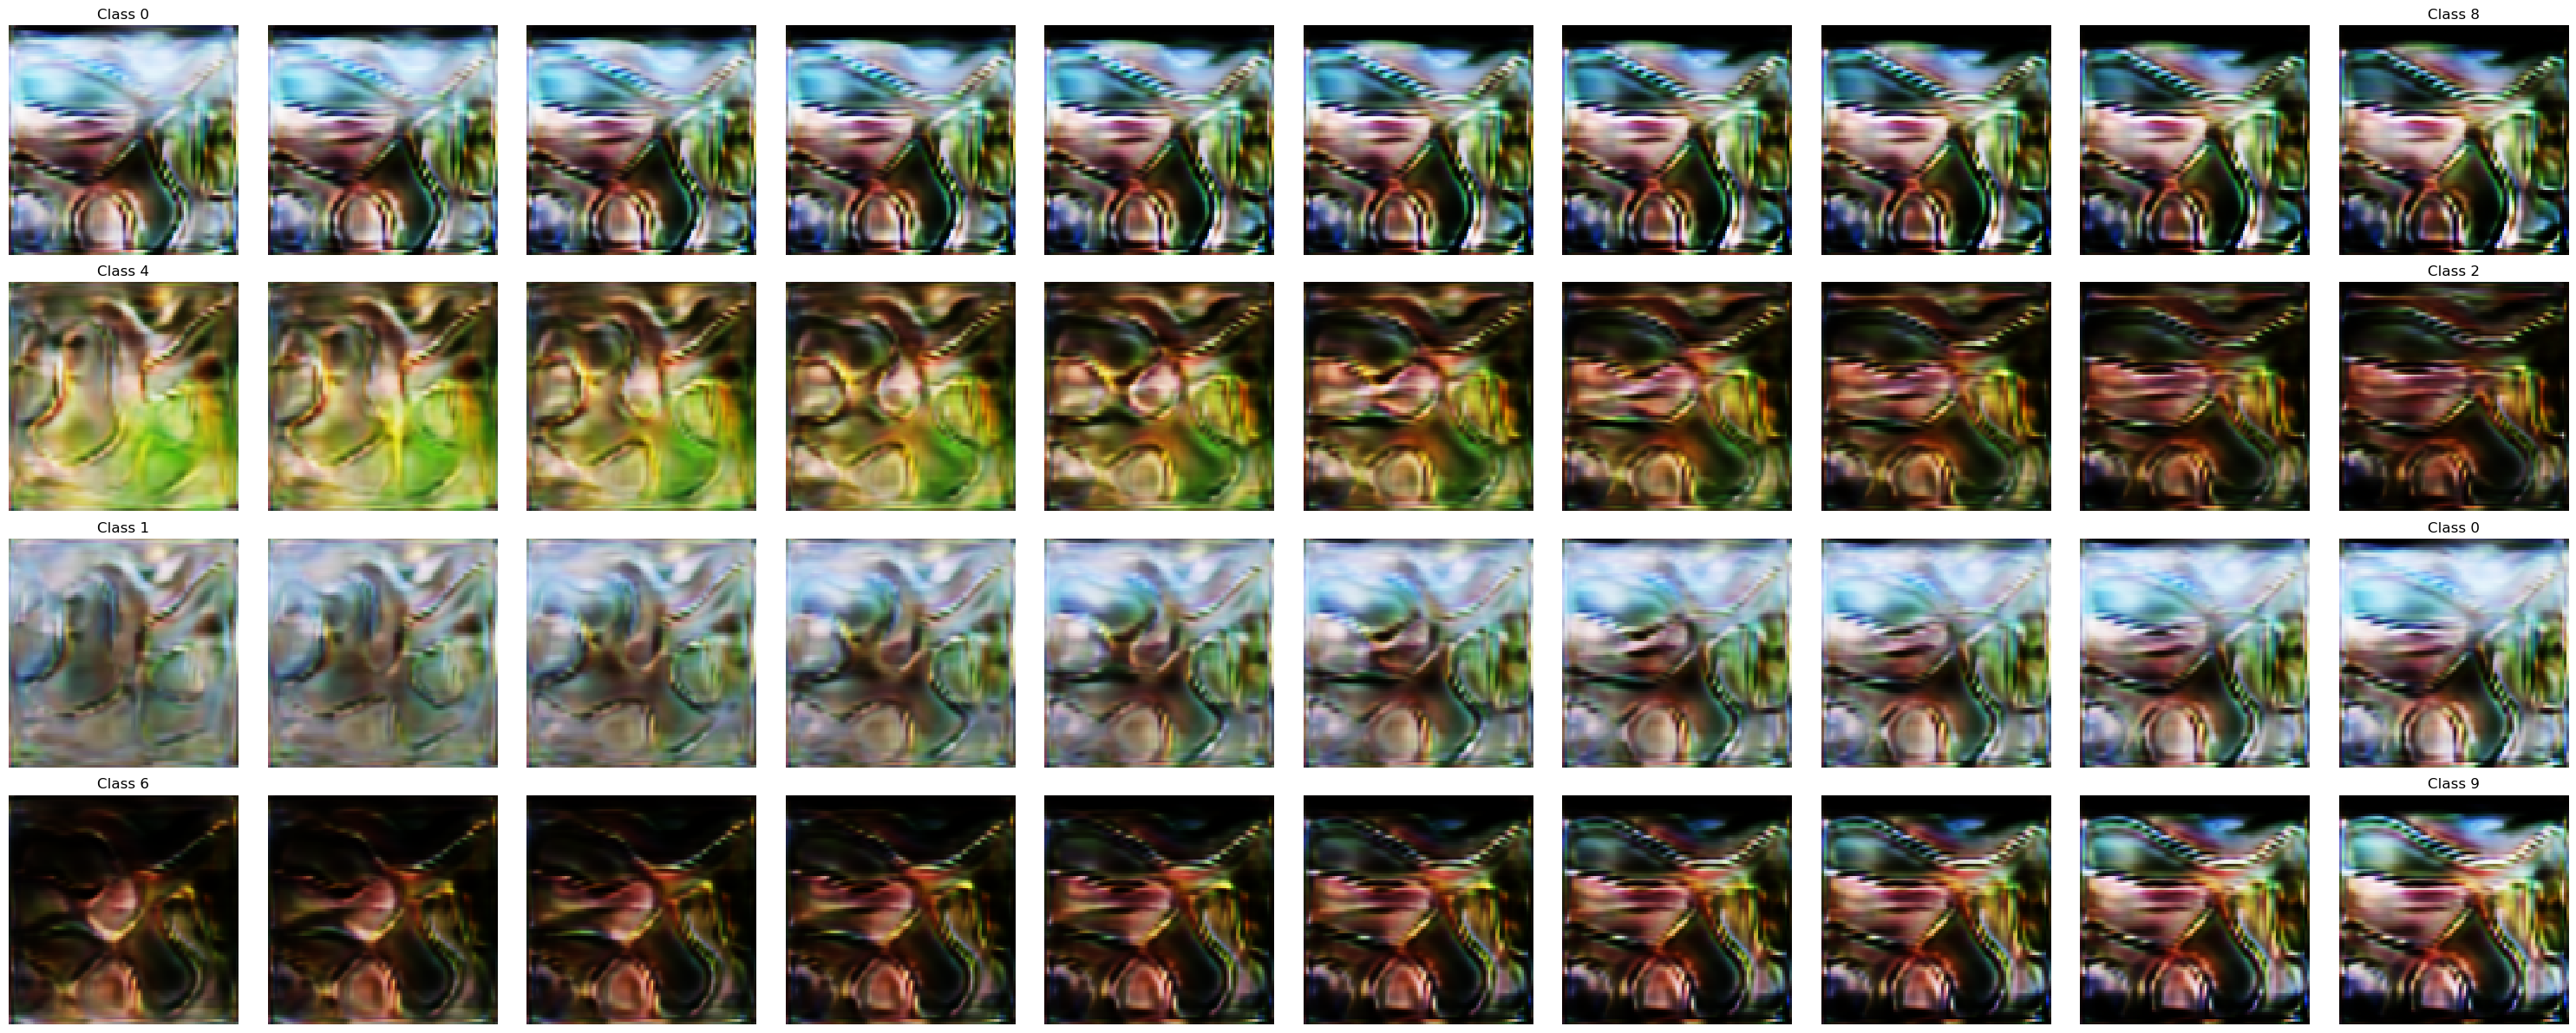